In [1]:
# Temporary import. It will be removed in the final vserion
import os
import sys

import os
os.chdir('/Users/zhanwenxin/Documents/GitHub/cuTAGI-LSTM')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import pytagi.metric as metric
from pytagi import Normalizer as normalizer
from pytagi import exponential_scheduler
from pytagi.nn import LSTM, Linear, Sequential

from examples.data_loader import TimeSeriesDataloader
from pytagi.hybrid import LSTM_SSM
from pytagi.hybrid import process_input_ssm

In [2]:
num_epochs: int = 1
batch_size: int = 1
sigma_v: float = 1

"""Run training for time-series forecasting model"""
# Dataset
output_col = [0]
num_features = 5
input_seq_len = 26
output_seq_len = 1
seq_stride = 1

# Network
net = Sequential(
    LSTM(num_features, 30, input_seq_len),
    LSTM(30, 30, input_seq_len),
    Linear(30 * input_seq_len, 1),
)
net.set_threads(8)
net.load(filename='./saved_param/HQ_hybrid_LSTM/lstm_hq_hybrid.pth')
# #net.to_device("cuda")

# # State-space models: for baseline hidden states
phi_AA = 0.999
Sigma_AR = 0.05
LA_var_stationary = Sigma_AR*1e-17 /(1-phi_AA**2)
# Autoregressive acceleration + online AR
hybrid = LSTM_SSM(
    neural_network = net,           # LSTM
    baseline = 'AA + AR', # 'level', 'trend', 'acceleration', 'ETS'
    zB  = np.array([0.1, 1E-4, 0, 0.5, 0.02]),    # initial mu for baseline hidden states
    SzB = np.array([1E-5, 1E-8, LA_var_stationary, 0.25, Sigma_AR]),    # var
    phi_AA = phi_AA,
    Sigma_AR = Sigma_AR
)

In [3]:
train_dtl = TimeSeriesDataloader(
    x_file="data/HQ/LGA007PIAP-E010_Y_train.csv",
    date_time_file="data/HQ/LGA007PIAP-E010_Y_train_datetime.csv",
    output_col=output_col,
    input_seq_len=input_seq_len,
    output_seq_len=output_seq_len,
    num_features=num_features,
    stride=seq_stride,
    time_covariates = ['week_of_year'],  # 'hour_of_day','day_of_week', 'week_of_year', 'month_of_year','quarter_of_year'
)
test_dtl = TimeSeriesDataloader(
    x_file="data/HQ/LGA007PIAP-E010_Y_val.csv",
    date_time_file="data/HQ/LGA007PIAP-E010_Y_val_datetime.csv",
    output_col=output_col,
    input_seq_len=input_seq_len,
    output_seq_len=output_seq_len,
    num_features=num_features,
    stride=seq_stride,
    x_mean=train_dtl.x_mean,
    x_std=train_dtl.x_std,
    time_covariates = ['week_of_year'],  # 'hour_of_day','day_of_week', 'week_of_year'
)

In [4]:
# -------------------------------------------------------------------------#
# Training
mses = []

pbar = tqdm(range(num_epochs), desc="Training Progress")
for epoch in pbar:
    batch_iter = train_dtl.create_data_loader(batch_size, shuffle=False)

    # Decaying observation's variance
    sigma_v = exponential_scheduler(
        curr_v=1E-12, min_v=1E-12, decaying_factor=1, curr_iter=epoch
    )
    var_y = np.full((batch_size * len(output_col),), sigma_v**2, dtype=np.float32)

    # Initialize list to save
    hybrid.init_ssm_hs()
    mu_preds_lstm = []
    var_preds_lstm = []
    mu_preds_unnorm = []
    obs_unnorm = []
    mu_ar = []
    var_ar = []
    mu_aa = []
    var_aa = []

    for x, y in batch_iter:
        mu_x, var_x = process_input_ssm(
            mu_x = x, mu_preds_lstm = mu_preds_lstm, var_preds_lstm = var_preds_lstm,
            input_seq_len = input_seq_len, num_features = num_features,
            )

        # Feed forward
        y_pred, _, z_pred, Sz_pred, m_pred, v_pred = hybrid(mu_x, var_x)
        # Backward
        hybrid.backward(mu_obs = y, var_obs = var_y, train_LSTM = False)

        # Training metric
        pred = normalizer.unstandardize(
            y_pred.flatten(), train_dtl.x_mean[output_col], train_dtl.x_std[output_col]
        )
        obs = normalizer.unstandardize(
            y, train_dtl.x_mean[output_col], train_dtl.x_std[output_col]
        )
        mse = metric.mse(pred, obs)
        mses.append(mse)
        mu_preds_lstm.extend(m_pred)
        var_preds_lstm.extend(v_pred)
        obs_unnorm.extend(y)
        mu_preds_unnorm.extend(y_pred)
        mu_ar.append(z_pred[-3].item())
        var_ar.append(Sz_pred[-3][-3])
        mu_aa.append(z_pred[2].item())
        var_aa.append(Sz_pred[2][2])

    # Smoother
    hybrid.smoother()
    mu_smoothed = np.array(hybrid.mu_smoothed)
    cov_smoothed = np.array(hybrid.cov_smoothed)

    # Progress bar
    pbar.set_description(
        f"Epoch {epoch + 1}/{num_epochs}| mse: {np.nanmean(mses):>7.2f}",
        refresh=True,
    )

Training Progress:   0%|          | 0/1 [00:00<?, ?it/s]/Users/zhanwenxin/Documents/GitHub/cuTAGI-LSTM/pytagi/metric.py:29: RuntimeWarning: Mean of empty slice
  return np.nanmean((prediction - observation) ** 2)
Epoch 1/1| mse:    0.01: 100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


In [9]:
print(train_dtl.x_mean[output_col])
print(train_dtl.x_std[output_col])

[1.29422196]
[1.04736457]


In [5]:
# Testing
test_batch_iter = test_dtl.create_data_loader(batch_size, shuffle=False)

# Initialize list to save
mu_preds = []
var_preds = []
y_test = []
obs_test_unnorm = []
#

for x, y in test_batch_iter:
    mu_x, var_x = process_input_ssm(
        mu_x = x, mu_preds_lstm = mu_preds_lstm, var_preds_lstm = var_preds_lstm,
        input_seq_len = input_seq_len,num_features = num_features,
    )
    # Feed forward
    y_pred, Sy_red, _, _, m_pred, v_pred = hybrid(mu_x, var_x)

    mu_preds.extend(y_pred)
    var_preds.extend(Sy_red + sigma_v**2)
    y_test.extend(y)
    mu_preds_lstm.extend(m_pred)
    var_preds_lstm.extend(v_pred)

mu_preds = np.array(mu_preds)
std_preds = np.array(var_preds) ** 0.5
y_test = np.array(y_test)
obs_test_unnorm = y_test
mu_preds_unnorm_test = mu_preds
std_preds_unnorm_test = std_preds

mu_preds = normalizer.unstandardize(
    mu_preds, train_dtl.x_mean[output_col], train_dtl.x_std[output_col]
)
std_preds = normalizer.unstandardize_std(std_preds, train_dtl.x_std[output_col])

y_test = normalizer.unstandardize(
    y_test, train_dtl.x_mean[output_col], train_dtl.x_std[output_col]
)

#############
MSE           :  2.18
Log-likelihood: -18.36


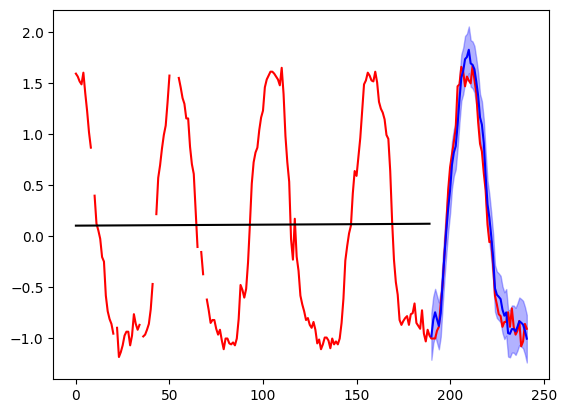

In [6]:
# Compute log-likelihood
mse = metric.mse(mu_preds, y_test)
log_lik = metric.log_likelihood(
    prediction=mu_preds, observation=y_test, std=std_preds
)

#
obs = np.concatenate((obs_unnorm,obs_test_unnorm), axis=0)
idx_train = range(0,len(obs_unnorm))
idx_test = range(len(obs_unnorm),len(obs))
idx = np.concatenate((idx_train,idx_test),axis=0)
mu_preds_unnorm_test = mu_preds_unnorm_test.flatten()
std_preds_unnorm_test = std_preds_unnorm_test.flatten()

# figure for final test predictions
plt.figure()
plt.plot(idx,obs, color='r',label=r"data")
plt.plot(idx_test, mu_preds_unnorm_test, color='b',label=r"test prediction")
plt.fill_between(idx_test, mu_preds_unnorm_test - std_preds_unnorm_test, mu_preds_unnorm_test + std_preds_unnorm_test, color='blue', alpha=0.3, label='±1 SD')
plt.plot(idx_train,mu_smoothed[:,0,:],color='k',label=r"level")

print("#############")
print(f"MSE           : {mse: 0.2f}")
print(f"Log-likelihood: {log_lik: 0.2f}")